*Copyright 2024 Google LLC.*

*Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at*

     http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.*

# FeedX Experiment Designer

[![Open in Colab](https://img.shields.io/badge/Open_in_Colab-blue?style=flat&logo=google%20colab&labelColor=grey)](https://colab.research.google.com/github/google-marketing-solutions/feedx/blob/main/notebooks/01_experiment_designer.ipynb)  
[![Open in Github](https://img.shields.io/badge/Open_in_Github-blue?style=flat&logo=Github&labelColor=grey)](https://github.com/google-marketing-solutions/feedx/blob/main/notebooks/01_experiment_designer.ipynb)  
[![Open in NBViewer](https://img.shields.io/badge/Open_in_NBViewer-blue?style=flat&logo=jupyter&labelColor=grey)](https://nbviewer.org/github/google-marketing-solutions/feedx/blob/main/notebooks/01_experiment_designer.ipynb)

Welcome to the FeedX experiment designer. This notebook walks you through the process of designing a new FeedX experiment to test changes to your Merchant Center shopping feed. We will:

1. Load, process and validate the historical data.
2. Set the candidate designs to simulate. These are all of the different experiment designs you want to compare.
3. Estimate the minimum detectable effect (MDE) of every design and compare them.
4. Select the best design and validate that the statistical assumptions are met with a simulation study.
5. Perform the item randomisation and create the treatment and control groups for the experiment.
6. Export the treatment assignments and the selected design.

## Install FeedX if not already installed



In [ ]:
!pip install feedx

## Import Packages

In [ ]:
from feedx import experiment_simulations
from feedx import experiment_design
from feedx import data_preparation
from feedx import plotting

import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

## Authorise access to google drive (optional)

Run the cell below to allow access to data from google drive. This is only needed if you are loading the data from Google Drive, otherwise you can skip this cell. Upon running this cell, you will be asked to authenticate your google account, follow the steps and then return to this notebook.

In [ ]:
from google.colab import auth
from google.auth import default
import gspread

auth.authenticate_user()
GOOGLE_CREDENTIALS, _ = default()
GSPREAD_CLIENT = gspread.authorize(GOOGLE_CREDENTIALS)

Beginning OAuth2 authorization process ...
Authentication successful.


## Mount google drive (optional)

This cell mounts google drive to this Colab notebook. This is only needed if you are loading the data from a CSV stored in google drive (data loading options 3 or 4), it's not needed if you are loading the data from a Google Sheet.

In [ ]:
from google.colab import drive

DRIVE_LOCATION = "/content/drive"
drive.mount(DRIVE_LOCATION)

## Set a random seed

This makes this notebook reproducable, so that if you run it again in the future with the same data and same seed, you will get exactly the same results.

In [ ]:
RANDOM_SEED = 1234 #@param {type:"integer"}

RNG = np.random.default_rng(RANDOM_SEED)

## Load Historical Data

The experiments are designed by running simulations using your historical data, so now you must load it. **There are different options below for how you can load the data, depending on where it has been stored. You only need to run one, and you don't need to run the others.**

The historical data must contain at least three columns (if it contains more, the other columns are ignored):

* Item ID: This is the identifier of the item
* Date: This is either the date for daily data, or the start of the week for weekly data.
* [Primary Metric]: This should be the value of your primary metric, for that item id on that date / week.

The primary metric can be anything, but we recommend clicks.

If you have a very large number of items, and you don't want to run your experiment with all of them, then you can donwsample your data here by setting the `item_sample_fraction < 1.0`. For example, if you set it to 0.8 then you will keep a random 80% of the items and drop 20%.

For more details on the data required and how to get it, see the README.

### Option 1: Create Synthetic Data

**DO NOT USE THIS FOR ANY REAL EXPERIMENTS.**

This option is just to demonstrate the notebook. It will generate daily synthetic data where clicks is the primary metric.

In [ ]:
primary_metric = "clicks"
date_column_name = "date"
item_id_column_name = "item_id"
primary_metric = "clicks"
primary_metric_column_name = "clicks"
item_sample_fraction = 1.0

raw_data = data_preparation.generate_synthetic_data(rng=RNG)
raw_data.head()

,date,item_id,impressions,clicks,conversions,total_cost,total_conversion_value
0,2023-01-01,item_0,4,0,0,0.0,0.0
1,2023-01-02,item_0,2,0,0,0.0,0.0
2,2023-01-03,item_0,2,0,0,0.0,0.0
3,2023-01-04,item_0,2,0,0,0.0,0.0
4,2023-01-05,item_0,2,0,0,0.0,0.0


### Option 2: Load data from a Google Sheet

If you have your historical data in a google sheet, stored on google drive, you can load it with this cell. The first row in the sheet should be the column names, and the rest of the rows the values.

You need to provide:

* **`google_sheet_url`**: The URL to the sheet.
* **`worksheet_name`**: The name of the worksheet (tab) containing the data. If empty it will load the first worksheet.
* **`date_column_name`**: The name of the column in the google sheet containing the dates.
* **`item_id_column_name`**: The name of the column in the google sheet containing the item id.
* **`primary_metric`**: What primary metric are you using?
* **`primary_metric_column_name`**: The column name in the google sheet containing the primary metric.


In [ ]:
google_sheet_url = "" #@param {type:"string"}
worksheet_name = "" #@param {type:"string"}
date_column_name = "Week" #@param {type:"string"}
item_id_column_name = "Item ID" #@param {type:"string"}
primary_metric = "clicks" #@param ["clicks", "impressions", "conversions", "total_conversion_value", "total_cost", "other"]
primary_metric_column_name = "Clicks" #@param {type:"string"}
item_sample_fraction = 1.0 #@param {type:"number"}


def load_data_from_google_sheet(url: str, worksheet_name: str, client: gspread.Client) -> pd.DataFrame:
  """Loads data from a Google Sheet to pandas dataframe."""
  input_sheet = client.open_by_url(url)

  if worksheet_name:
    values = input_sheet.worksheet(worksheet_name).get_all_values()
  else:
    values = input_sheet.sheet1.get_all_values()

  return pd.DataFrame.from_records(values[1:], columns=values[0])

raw_data = load_data_from_google_sheet(
    url=google_sheet_url, worksheet_name=worksheet_name, client=GSPREAD_CLIENT
)
raw_data.head()

### Option 3: Load data from another CSV file

Use this if you have downloaded your historical data from Google Ads as a CSV and either stored that on Google Drive and mounted Google Drive to this notebook, or uploaded the CSV to Colab directly.

The values are good defaults that normally work when downloading the historical performance data from Google Ads as described in the README. If it doesn't work because your CSV is different they can be changed.

You can to provide:

* **`csv_path`**: The path to the CSV relative to this notebook.
* **`date_column_name`**: The name of the column in the google sheet containing the dates.
* **`item_id_column_name`**: The name of the column in the google sheet containing the item id.
* **`primary_metric`**: What primary metric are you using?
* **`primary_metric_column_name`**: The column name in the google sheet containing the primary metric.
* **`header_rows`**: The row number in the CSV containing the column names (0 indexed). Any rows above this will be skipped.
* **`thousands_separator`**: The separator for thousands in the csv. E.g. a comma means thousands are written like 1,000.

In [ ]:
csv_path = "" #@param {type:"string"}
date_column_name = "Week" #@param {type:"string"}
item_id_column_name = "Item ID" #@param {type:"string"}
primary_metric = "clicks" #@param ["clicks", "impressions", "conversions", "total_conversion_value", "total_cost", "other"]
primary_metric_column_name = "Clicks" #@param {type:"string"}
item_sample_fraction = 1.0 #@param {type:"number"}

header_rows = 2 #@param {type:"number"}
thousands_separator = "," #@param {type:"string"}
if thousands_separator == "":
  thousands_separator = None

raw_data = pd.read_csv(
    csv_path,
    header=header_rows,
    thousands=thousands_separator
)
raw_data.head()

## Prepare, summarise and plot data

Here we prepare and perform some validation on the data. The validation checks can be skipped by adding their names to `skip_validation_checks`, comma separated if there is more than one. Ideally the validation checks should not be skipped, and the data should be fixed if any of them fail, unless you have a good reason to allow the check to fail.

One example of a good reason to skip a validation check is that by default the primary metric is validated to be non-negative. This is good for most primary metrics which usually are non-negative (clicks, impressions, conversions, cost and conversion value are all non-negative). However, if you have a custom metric that can be negative then you will want to disable this check by adding "all_metrics_are_non_negative" to skip_validation_checks.

In [ ]:
skip_validation_checks = "" #@param {type:"string"}
skip_validation_checks = list(filter(lambda x: x, map(lambda x: x.strip(), skip_validation_checks.split(","))))

historical_data = data_preparation.prepare_and_validate_historical_data(
    raw_data,
    item_id_column=item_id_column_name,
    date_column=date_column_name,
    primary_metric=primary_metric,
    primary_metric_column=primary_metric_column_name,
    rng=RNG,
    item_sample_fraction=item_sample_fraction,
    skip_validation_checks=skip_validation_checks
)

if primary_metric == "other":
  primary_metric = primary_metric_column_name

historical_data.head()

The input data is daily, grouping to weekly.
Data has 91000 rows and 7000 items.
Not downsampling, since the downsample_fraction = 1.0
Validation check 'no_nulls' passed. 
Validation check 'no_duplicate_items_per_date' passed. All week_start have 7,000 item_id.
Validation check 'dates_are_daily_or_weekly' passed. Dates are weekly.
Validation check 'week_ids_are_consecutive_integers' passed. Week ids are consecutive integers.
Validation check 'all_metrics_are_finite' passed. The following metric values are all finite: ['clicks'].
Validation check 'all_metrics_are_non_negative' passed. The following metric values are all non-negative: ['clicks'].


,week_id,week_start,item_id,clicks
0,0,2023-01-01,item_0,0.0
1,0,2023-01-01,item_1,0.0
2,0,2023-01-01,item_10,0.0
3,0,2023-01-01,item_100,512.0
4,0,2023-01-01,item_1000,0.0


Below you can see the weekly performance of your primary metric over time (left) and the distribution of your primary metric per item per week (right).

**It's important to check whether the first and last week have significantly lower values than the other weeks.** If they do, this could indicate that when you loaded the data, your filtering was not aligned with the week start dates, meaning the first and last week are missing days. Either exclude these weeks or re-pull the data.

In [ ]:
def print_metric_summary(data: pd.DataFrame, metric_column: str) -> None:
  metric = data[metric_column]
  print(f"{data.item_id.nunique():,} total items.")
  print(f"{data.week_id.nunique():,} complete weeks of data.")
  print(f"Average {metric_column} per product per week: {metric.mean()}")
  print(f"Share of item/day combinations with at {metric_column} > 0 click: {(metric > 0).mean():.4%}")

print_metric_summary(historical_data, primary_metric)

7,000 total items.
13 complete weeks of data.
Average clicks per product per week: 7.034736263736264
Share of item/day combinations with at clicks > 0 click: 41.6956%


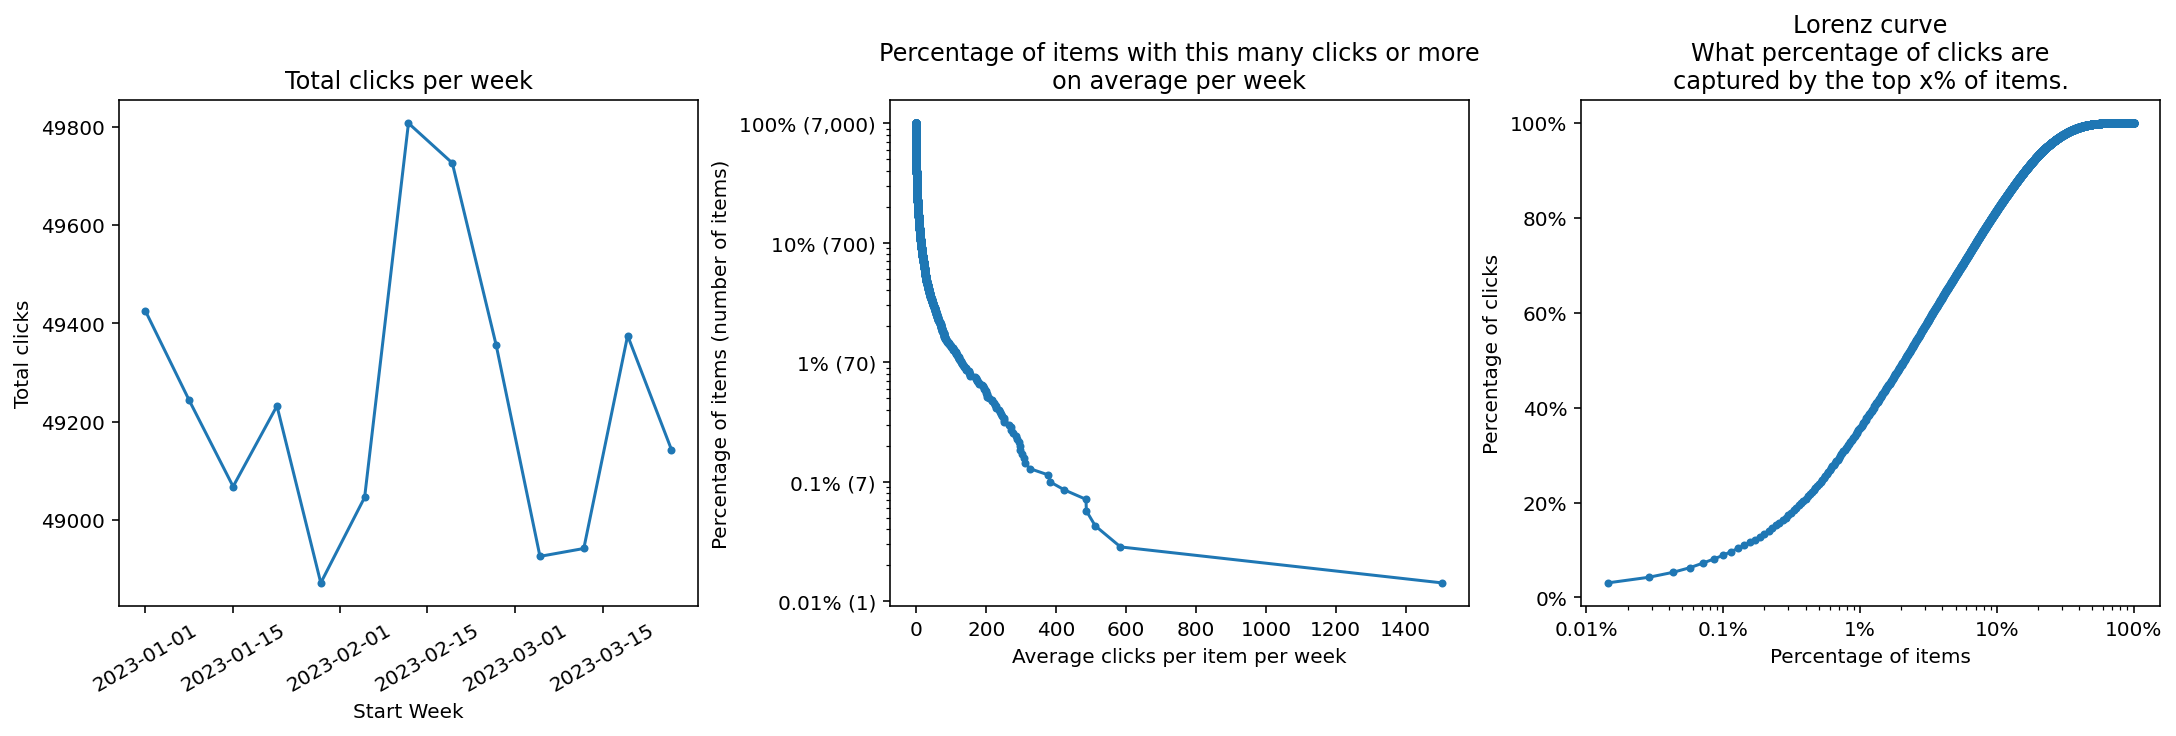

In [ ]:
plotting.plot_metric_history(historical_data, primary_metric)
plt.show()

## Estimate minimum detectable effects

Now the data is loaded and validated, we can use it to simulate a range of experiment designs. In this cell you can put all of the possible options for each of the experiment design parameters that you would consider for your experiment. The design parameters are:

* **`candidate_runtime_weeks`**: The total runtime of the experiment, in weeks. This is the end to end runtime, including any crossover washout etc. Put a list of all the runtimes you would consider, separated by commas.
* **`candidate_pretest_weeks`**: The number of weeks before the start of the experiment to use for pre-trimming and the cuped adjustment (if applicable). Put a list of all pre-test durations you would consider, separated by commas.
* **`candidate_pre_trim_top_percentiles`**: The fraction of items with the highest primary metric during the pretest period to remove from the experiment. E.g. 0.01 would remove the top 1%. This should be kept as small as possible, and only done if the data is very skewed (there are a small number of outlier hero items that get much higher performance than anything else). Put a list of all pre-trim top percentiles you would consider, separated by commas.
* **`candidate_pre_trim_bottom_percentiles`**: The fraction of items with the lowest primary metric during the pretest period to remove from the experiment. E.g. 0.01 would remove the bottom 1%. This should be kept as small as possible, and only done if there are some items that have such low performance they are difficult to measure. Put a list of all pre-trim bottom percentiles you would consider, separated by commas.
* **`candidate_post_trim_percentiles`**: The fraction of items with the lowest and highest primary metric during the runtime of the experiment to exclude from the analysis. E.g. 0.01 would remove the top and bottom 1%. This should be kept as small as possible, and only done if it's needed to remove outlier / hero items. Put a list of all post-trim percentiles you would consider, separated by commas. This can be done instead of or in combination with pre-trimming. If you are considering trimming, it's best to try both pre and post trimming and see what gives the lowest MDE. Note: with post trimming, the trimmed items are still exposed to the experiment, they are just ignored when analysing the experiment, while with pre-trimming the trimmed items are not experimented with at all.
* **`crossover_design_allowed`**: Tick the box if you would consider running a crossover experiment. This is recommended as they typically have the best power.
* **`traditional_design_allowed`**: Tick the box if you would consider running a traditional (non-crossover) experiment. It's worth simulating the traditional experiment for comparison with the crossover, to check that it's worth running the crossover. If the MDE is similar for both, it would be easier to run a traditional experiment, because you don't need to swap control and treatment half way through.
* **`crossover_washout_weeks`**: When running a crossover experiment, how many weeks should be excluded from the start of the experiment, and right after the crossover happens. This is done to avoid the results being contaminated by the data very close to the crossover, since the treatment could have a slightly delayed effect that could continue after the groups are swapped. Usually this is set to 1, but it can be increased.

For more of an explanation of these, see the README.

In [ ]:
candidate_runtime_weeks = "4,6,8" #@param {type:"string"}
candidate_pretest_weeks = "2,4" #@param {type:"string"}
candidate_pre_trim_top_percentiles = "0.0, 0.001" #@param {type:"string"}
candidate_pre_trim_bottom_percentiles = "0.0" #@param {type:"string"}
candidate_post_trim_percentiles = "0.0, 0.001" #@param {type:"string"}
crossover_design_allowed = True #@param {type:"boolean"}
traditional_design_allowed = True #@param {type:"boolean"}
crossover_washout_weeks = 1 #@param {type:"integer"}

if crossover_design_allowed & (crossover_washout_weeks < 1):
  raise ValueError("crossover_washout_weeks must be greater than 0 to avoid any leakage.")

candidate_runtime_weeks = list(map(
    lambda x: int(x.strip()),
    candidate_runtime_weeks.split(",")
))
candidate_pretest_weeks = list(map(
    lambda x: int(x.strip()),
    candidate_pretest_weeks.split(",")
))
candidate_pre_trim_top_percentiles = list(map(
    lambda x: float(x.strip()),
    candidate_pre_trim_top_percentiles.split(",")
))
candidate_pre_trim_bottom_percentiles = list(map(
    lambda x: float(x.strip()),
    candidate_pre_trim_bottom_percentiles.split(",")
))
candidate_post_trim_percentiles = list(map(
    lambda x: float(x.strip()),
    candidate_post_trim_percentiles.split(",")
))

experiment_designs = experiment_simulations.generate_all_valid_designs(
    n_items_before_trimming=historical_data['item_id'].nunique(),
    crossover_design_allowed=crossover_design_allowed,
    traditional_design_allowed=traditional_design_allowed,
    candidate_runtime_weeks=candidate_runtime_weeks,
    candidate_pretest_weeks=candidate_pretest_weeks,
    candidate_pre_trim_top_percentiles=candidate_pre_trim_top_percentiles,
    candidate_pre_trim_bottom_percentiles=candidate_pre_trim_bottom_percentiles,
    candidate_post_trim_percentiles=candidate_post_trim_percentiles,
    primary_metric=primary_metric,
    crossover_washout_weeks=crossover_washout_weeks,
)
minimum_start_week_id = experiment_simulations.calculate_minimum_start_week_id(
    candidate_runtime_weeks=candidate_runtime_weeks,
    candidate_pretest_weeks=candidate_pretest_weeks,
    historical_week_ids=historical_data["week_id"].unique()
)
print(f"Number of designs to simulate: {len(experiment_designs)}")
print(f"Minimum start week id: {minimum_start_week_id}")

Number of designs to simulate: 48
Minimum start week id: 4


The next cell will estimate the minimum detectable effect for all the designs generated above. This might take a few minutes if there are a lot of designs or if the historical data is very large.

In [ ]:
def make_analysis_and_estimate_minimum_detectable_effect(design: experiment_design.ExperimentDesign) -> experiment_simulations.SimulationAnalysis:
  analysis = experiment_simulations.SimulationAnalysis(
      design=design,
      historical_data=historical_data.copy(),
      item_id_column="item_id",
      week_id_column="week_id",
      minimum_start_week_id=minimum_start_week_id,
      rng=RNG
  )
  analysis.estimate_minimum_detectable_effect()
  return analysis

experiment_analyses = {
    analysis.design.design_id: analysis
    for analysis in tqdm.tqdm(
        map(make_analysis_and_estimate_minimum_detectable_effect, experiment_designs),
        desc="Estimating Minimum Detectable Effects",
        total=len(experiment_designs)
    )
}

Estimating Minimum Detectable Effects:   0%|          | 0/48 [00:00<?, ?it/s]

Below is the summary of all the designs, and their minimum detectable effects (MDEs), sorted by the relative MDE. The relative MDE is the smallest effect that you would be able to reliably measure in that experiment. If the feed optimization you are testing has a smaller impact than the MDE, then it's very unlikely you will get a statistically significant result.

It's important to think about how big an impact you expect your feed optimization to have, to know what a reasonable MDE would be. For example:

* If your feed is not well optimized, and these are your first big improvements, then you might expect a bigger impact, and so can accept a larger relative MDE.
* If your feed is already well optimized, and this is more of an incremental improvement, then you might expect a smaller impact, so you will require a smaller MDE.

Typically it's best to go for an MDE that is smaller than 5% if possible, but again this will depend on your situation.

If you have multiple designs that all have a relative MDE that is small enough, then it's usually best to select the design with the lowest relative MDE. However if multiple designs have similar relative MDE, you can choose the one that's easiest for you to run (shortest runtime for example).


In [ ]:
summary_data = experiment_simulations.make_analysis_summary_dataframe(experiment_analyses.values())
experiment_simulations.format_analysis_summary_dataframe(summary_data, with_validation_columns=False)

,Runtime Weeks,Pretest Weeks,Is Crossover,Pre Trim Top Percentile,Post Trim Percentile,Crossover Washout Weeks,N Items After Pre Trim,N Items After Post Trim,Minimum Detectable Effect,Relative Minimum Detectable Effect
design_id,,,,,,,,,,
64e697cee174d30b57994c99cdacd227,8,4,True,0.00%,0.00%,1.000000,7000,7000,0.071036,1.01%
969623c16b9b63ac97e33f349efbce7b,8,2,True,0.00%,0.00%,1.000000,7000,7000,0.071036,1.01%
f91089f6964f9746929e4f2b19cef5bb,8,4,True,0.00%,0.10%,1.000000,7000,6986,0.068278,1.05%
84f4c01566071b4f1000b0980c800d02,8,2,True,0.00%,0.10%,1.000000,7000,6986,0.068278,1.05%
ef5f67a9bbe4ddc18479e6992b7e79f2,8,2,True,0.10%,0.00%,1.000000,6993,6993,0.069130,1.07%
36c7e03796c8cf9c532df7ed037b4cf3,8,4,True,0.10%,0.00%,1.000000,6993,6993,0.069138,1.07%
1c0432cbe9d57e0eeec681babd870e77,8,4,True,0.10%,0.10%,1.000000,6993,6981,0.067202,1.11%
dc073ef26a5a993686ee12922b45c6d3,8,2,True,0.10%,0.10%,1.000000,6993,6981,0.067202,1.11%
244de0cd55bd886d1e05c2873893e673,6,4,True,0.00%,0.00%,1.000000,7000,7000,0.086837,1.23%


## Run validation simulations

Now you can select your most promising design(s), and validate that they meet the statistical assumptions that FeedX makes. It does this by simulating 500 (or more) experiments on the historical data and testing that the results look as you would expect.

Usually this will pass, but see the README for more info on what to do if it fails.

You need to set the following parameters:

* **`n_simulations_per_design`**: The number of simulations to perform per design. Should be at least 500.
* **`design_ids_for_validation`**: The design ids (copied from the table above) to validate. Typically just choose 1 or 2 that have the best relative MDEs.
* **`force_revalidate`**: By default the validation will skip any designs that it has already validated. To force it to validate them again, tick this box.

Note: This step can take some time, especially if your data is large.

In [ ]:
n_simulations_per_design = 500 #@param {type:"integer"}
design_ids_for_validation = "64e697cee174d30b57994c99cdacd227,f91089f6964f9746929e4f2b19cef5bb\t" #@param {type:"string"}
force_revalidate = False #@param {type:"boolean"}

design_ids_for_validation = list(map(lambda x: x.strip(), design_ids_for_validation.split(",")))

for design_id in design_ids_for_validation:
  if (not force_revalidate) & (experiment_analyses[design_id].simulated_false_positive_rate is not None):
    print(f"Design {design_id} already validated, not re-validating.")
    continue

  experiment_analyses[design_id].validate_design(n_simulations_per_design)

Validating 64e697cee174d30b57994c99cdacd227:   0%|          | 0/500 [00:00<?, ?it/s]

Validating f91089f6964f9746929e4f2b19cef5bb:   0%|          | 0/500 [00:00<?, ?it/s]

Below is the summary of the designs again, but now with the validation results. Check that all the validation checks are True.

In [ ]:
summary_data = experiment_simulations.make_analysis_summary_dataframe(experiment_analyses.values())
experiment_simulations.format_analysis_summary_dataframe(summary_data)

,Runtime Weeks,Pretest Weeks,Is Crossover,Pre Trim Top Percentile,Post Trim Percentile,Crossover Washout Weeks,N Items After Pre Trim,N Items After Post Trim,Minimum Detectable Effect,Relative Minimum Detectable Effect,Simulated False Positive Rate,Simulated Power At Minimum Detectable Effect,Null P Value Robustness Check Pass,Power Robustness Check Pass,False Positive Rate Robustness Check Pass,Aa Point Estimate Robustness Check Pass,Ab Point Estimate Robustness Check Pass,All Robustness Checks Pass
design_id,,,,,,,,,,,,,,,,,,
64e697cee174d30b57994c99cdacd227,8,4,True,0.00%,0.00%,1.000000,7000,7000,0.071036,1.01%,4.60%,82.20%,True,True,True,True,True,True
969623c16b9b63ac97e33f349efbce7b,8,2,True,0.00%,0.00%,1.000000,7000,7000,0.071036,1.01%,nan%,nan%,None,None,None,None,None,None
f91089f6964f9746929e4f2b19cef5bb,8,4,True,0.00%,0.10%,1.000000,7000,6986,0.068278,1.05%,4.80%,81.00%,True,True,True,True,True,True
84f4c01566071b4f1000b0980c800d02,8,2,True,0.00%,0.10%,1.000000,7000,6986,0.068278,1.05%,nan%,nan%,None,None,None,None,None,None
ef5f67a9bbe4ddc18479e6992b7e79f2,8,2,True,0.10%,0.00%,1.000000,6993,6993,0.069130,1.07%,nan%,nan%,None,None,None,None,None,None
36c7e03796c8cf9c532df7ed037b4cf3,8,4,True,0.10%,0.00%,1.000000,6993,6993,0.069138,1.07%,nan%,nan%,None,None,None,None,None,None
1c0432cbe9d57e0eeec681babd870e77,8,4,True,0.10%,0.10%,1.000000,6993,6981,0.067202,1.11%,nan%,nan%,None,None,None,None,None,None
dc073ef26a5a993686ee12922b45c6d3,8,2,True,0.10%,0.10%,1.000000,6993,6981,0.067202,1.11%,nan%,nan%,None,None,None,None,None,None
244de0cd55bd886d1e05c2873893e673,6,4,True,0.00%,0.00%,1.000000,7000,7000,0.086837,1.23%,nan%,nan%,None,None,None,None,None,None


## Select and export experiment design and treatment assignment

If the validation checks pass, select the design ID. **This is the design you will be using for your experiment.**

In [ ]:
selected_design_id = "64e697cee174d30b57994c99cdacd227" #@param {type:"string"}
selected_design_analysis = experiment_analyses[selected_design_id]
selected_design = selected_design_analysis.design
print(selected_design)

Design 64e697cee174d30b57994c99cdacd227

	Experiment type: crossover experiment
	Primary metric: clicks
	Number of weeks of data before start of experiment used for analysis: 4
	Total experiment runtime weeks: 8

Crossover Details:

	Control and treatment to be swapped 4 weeks after starting the experiment
	Number of crossover washout weeks to ignore at start of each period: 1
	Weeks [1, 5] are the washout weeks to be excluded from the analysis

Number of items for testing:

	Number of items: 7000
	No hero / outlier trimming used

Extra details:

	Alpha threshold: 0.05
	Power: 0.8
	Coinflip salt: None


Plot some of the simulated data from the validation checks for this design, and check visually that it looks good (the titles of the plots explain what to look for). This is just to visually double check what the validation checks above already checked.

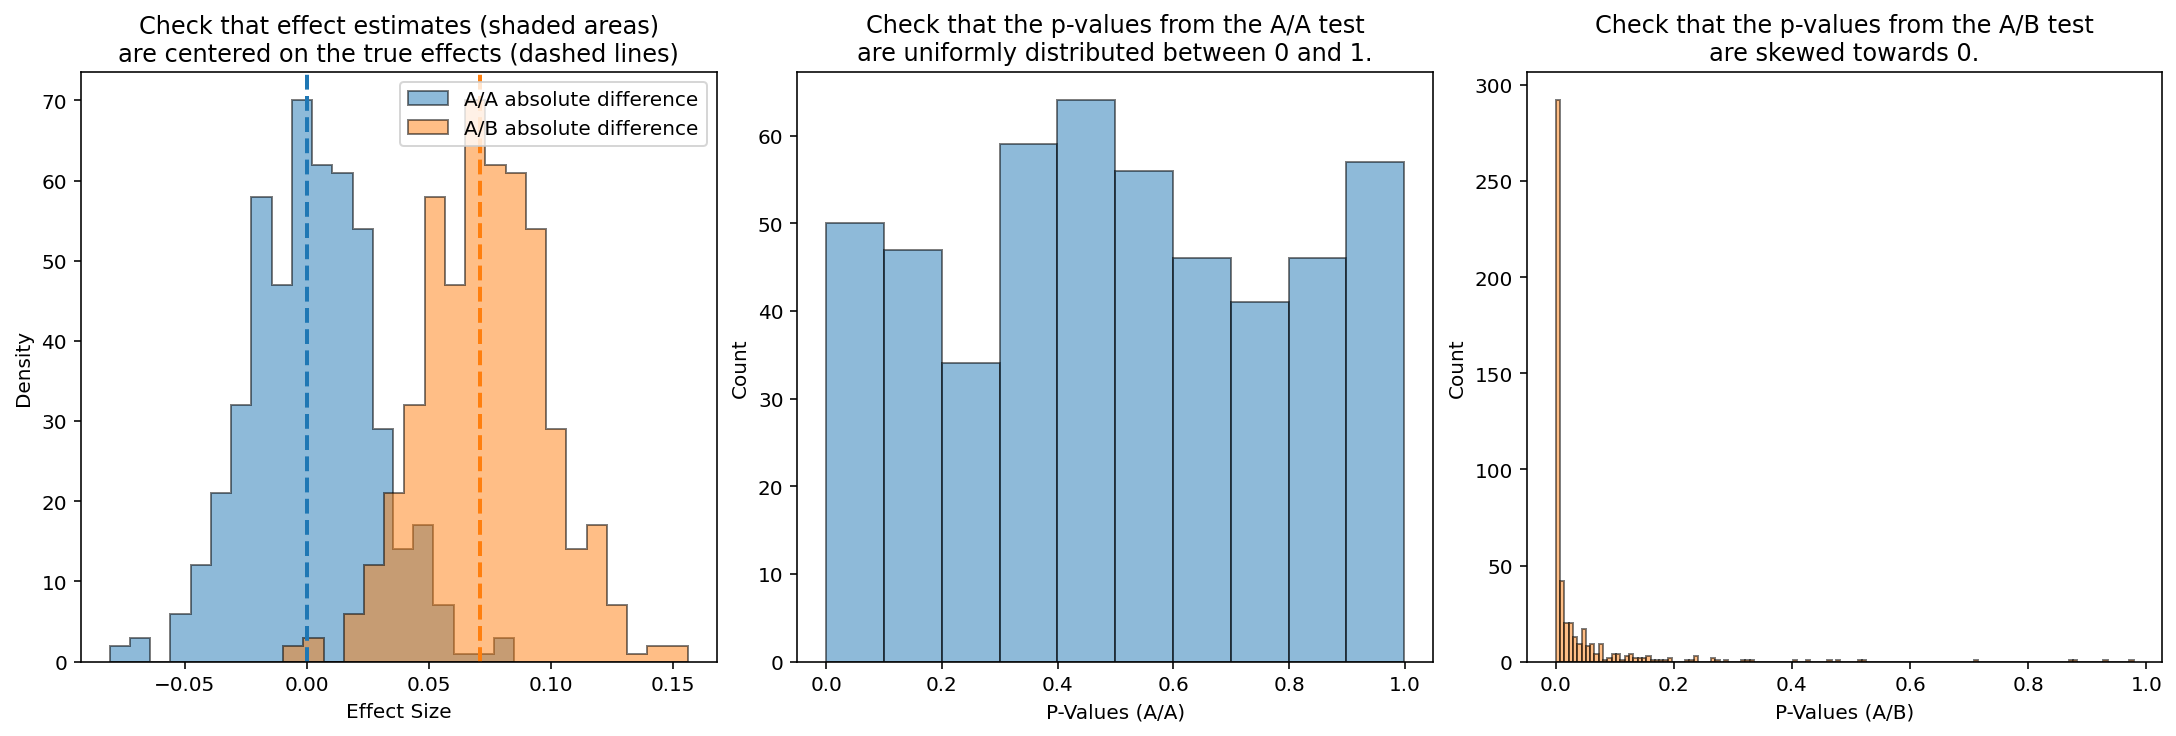

In [ ]:
plotting.plot_deep_dive(selected_design_analysis)
plt.show()

### Perform treatment assignment

This will randomly assign the items the treatment assignment 0 or 1 (explained below). Also if your selected design has any pre-trimming it will perform the pre-trimming. The result is a dataframe containing all of the items that will be used in the experiment, and their treatment group assignment.

The randomisation is done with a coinflip function, which will either use the coinflip salt from the design, or if it is not set it will generate a random one. The coinflip salt ensures that the item randomisation is reproducable, if you re-apply the randomisation with the same salt and item_id, it will always assign it to the same treatment group. Therefore if the treatment assignment is lost it can always be re-generated.

What the treatment assignments mean depends on whether you are running a crossover or non-crossover experiment:

* If the experiment is a **traditional (non-crossover) experiment**, then 0 means the item is in the control group, and so should not recieve the treatment and 1 means the item is in the treatment group and so should recieve the treatment.
* If the experiment is a **crossover experiment**, then 1 means the item should be treated in the first half of the experiment and not treated in the second half, while 0 means the item should not be treated in the first half of the experiment and should be treated in the second half.

In [ ]:
if selected_design_analysis.simulated_false_positive_rate is None:
  raise ValueError("Cannot export because the validation has not been run. Run the validation cell for this design first.")

if not selected_design_analysis.all_robustness_checks_pass:
  raise ValueError("Cannot export because the validation did not pass. Investigate the root cause of this, or select a different design.")

experiment_items = data_preparation.perform_treatment_assignment(
    historical_data,
    design=selected_design,
    rng=RNG,
    item_id_column="item_id",
    week_id_column="week_id",
)
experiment_items.head()

Generating random coinflip salt: e0676bc1ab3f0a27f758
Validation check 'no_sample_ratio_mismatch' passed. No Sample Ratio Mismatch.


,item_id,treatment_assignment
0,item_0,1
1,item_1,1
2,item_10,0
3,item_100,0
4,item_1000,1


### Write selected experiment design to yaml

We need to store the experiment design so that it can be re-used for the analysis at the end of the experiment. After running this cell, download the yaml file (or put it on Google Drive), and keep it safe.

In [ ]:
design_yaml_file_name = "selected_experiment_design.yaml" #@param {type:"string"}

if not design_yaml_file_name.endswith(".yaml"):
  raise ValueError("The design file name must end with .yaml")

selected_design.write_to_yaml(design_yaml_file_name)
print(f"Design {selected_design_id} exported to {design_yaml_file_name}.")
print("")
print(selected_design)

### Option 1: Write treatment assignment to Google Sheets

Write the item treatment assignments to a google sheet, which can then be used to create the supplemental feed for the experiment. This will print a URL to the sheet once it's complete.

In [ ]:
treatment_assignment_sheet_name = "feedx_treatment_assignment" #@param {type:"string"}

worksheet = GSPREAD_CLIENT.create(treatment_assignment_sheet_name)

values = experiment_items.values.tolist()
values.insert(0, ["Item ID", "Treatment Assignment"])

worksheet.sheet1.update(f'A1:B{len(values)+1}', values)

print(f"Treatment assignment stored in google sheet: {worksheet.url}")

### Option 2: Write treatment assignment to CSV

Write the item treatment assignments to a CSV file. You will then need to download the CSV file and use it to create the supplemental feed for the experiment.

In [ ]:
treatment_assignment_csv_path = "feedx_treatment_assignment.csv" #@param {type:"string"}

if not treatment_assignment_csv_path.endswith(".csv"):
  raise ValueError("The treatment assignment csv path must end with .csv")

experiment_items.to_csv(treatment_assignment_csv_path, index=False)